# Свинин Владимир (alelyya@gmail.com)
### Домашнее задание №3

Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения, c различными гиперпараметрами (коэффициент обучения и betas)
    * SGD, SGD+momentum, Adam

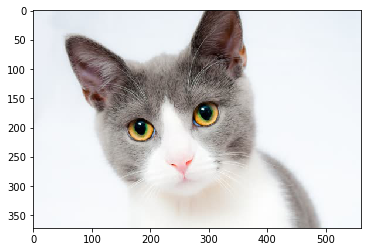

In [666]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

In [667]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve) # Превращаем кота в тензор

In [668]:
# Реализуем собственную свертку
from collections import namedtuple
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    dim = namedtuple('dim', ['c', 'h', 'w'])
    stride = dim(None, *stride)
    padding = dim(None, *padding)
    x_dim = dim(*x.size()[1:])
    k_dim = dim(*kernel.size()[1:])
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда
    :param  padding:  tuple - параметры паддинга
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    # lets add padding
    padded = torch.zeros([3, x_dim.h + padding.h*2, x_dim.w + padding.w*2])
    mask = padded.byte()
    mask[:, padding.h : padding.h + x_dim.h, padding.w : padding.w + x_dim.w ] = 1
    padded.masked_scatter_(mask, x)
    x = padded
    
    y_dim = [1, int((x_dim.h + 2*padding.h - k_dim.h) / stride.h + 1), int((x_dim.w +2*padding.w - k_dim.w) / stride.w + 1)]
    y = torch.zeros(y_dim, dtype=torch.float)
    for i in range(0, y_dim[1]):
        for j in range(0, y_dim[2]):
            start_h = i * stride.h
            start_w = j * stride.w
            y[0, i, j] = torch.sum(x[:, start_h:start_h+k_dim.h, start_w:start_w+k_dim.w] * kernel)
    return y

### Детектор границ

In [669]:
filter_kernel_1 = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel_1[:,1,1] = 8
print(filter_kernel_1[0])

tensor([[-1., -1., -1.],
        [-1.,  8., -1.],
        [-1., -1., -1.]])


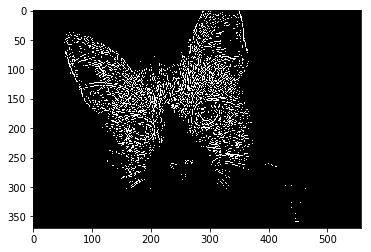

In [674]:
tensor = cat_tensor.unsqueeze(0)
kernel = filter_kernel_1.unsqueeze(0)

o_image = my_conv2d(tensor, kernel, padding = (0, 0))
o_image[o_image >= 0.5] = 1
o_image[o_image < 0.5] = 0

o_image.squeeze_(0)
plt.imshow(o_image.numpy(), cmap='gray')

### Горизонтальные границы

In [675]:
filter_kernel_2 = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel_2[:,1,:] = 0
filter_kernel_2[:,2,:] = -1
print(filter_kernel_2[0])

tensor([[ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.]])


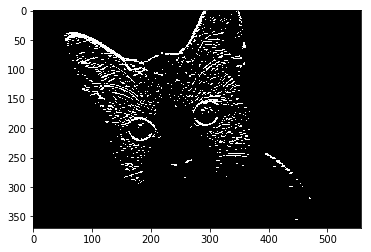

In [676]:
tensor = cat_tensor.unsqueeze(0)
kernel = filter_kernel_2.unsqueeze(0)

o_image = my_conv2d(tensor, kernel)
o_image[o_image >= 0.5] = 1
o_image[o_image < 0.5] = 0
o_image.squeeze_(0)
plt.imshow(o_image.numpy(), cmap='gray')

### Вертикальные границы

In [677]:
filter_kernel_3 = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel_3[:,:,1] = 0
filter_kernel_3[:,:,2] = -1
print(filter_kernel_3[0])

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])


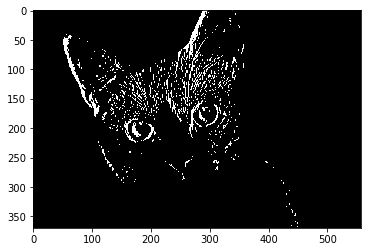

In [678]:
tensor = cat_tensor.unsqueeze(0)
kernel = filter_kernel_3.unsqueeze(0)
o_image = my_conv2d(tensor, kernel)
o_image[o_image >= 0.5] = 1
o_image[o_image < 0.5] = 0
o_image.squeeze_(0)
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

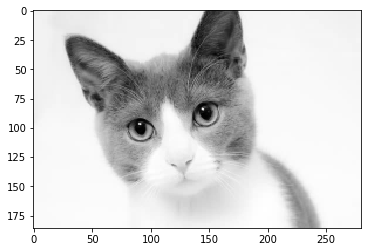

In [679]:
filter_kernel_4 = torch.FloatTensor(3,2,2).fill_(1)

tensor = cat_tensor.unsqueeze(0)
kernel = filter_kernel_4.unsqueeze(0)

o_image = my_conv2d(tensor, kernel, stride=(2,2))
o_image /= 4
o_image.squeeze_(0)
plt.imshow(o_image.numpy(), cmap='gray')

### Ядро свертки с гаусовым распределением

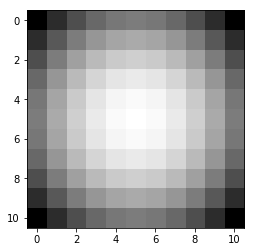

In [680]:
import scipy.ndimage as ndi
import numpy as np
sigma = 15    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

### Свертка с гауссовым размытием 

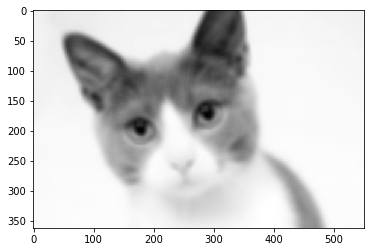

In [681]:
tensor = cat_tensor.unsqueeze(0)
kernel = torch.from_numpy(gause_kernel).float().unsqueeze(0).unsqueeze(0)

o_image = my_conv2d(tensor, kernel)
o_image.squeeze_(0)
plt.imshow(o_image.numpy(), cmap='gray')

# 2. Написать модуль батч нормализации для картинок
**Задача:** реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.



In [411]:
import torch.nn as nn
import math

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        self.in_channels = in_channels
        self.beta = beta
        self.epsilon = epsilon
        
        self.mean = torch.zeros(in_channels)
        self.var = torch.ones(in_channels)
        
        if afine:        
            self.gamma = torch.empty(in_channels).uniform_()
        else:
            self.gamma = torch.ones(in_channels)
        self.b = torch.zeros(in_channels)
        
        self.v = torch.zeros(in_channels)
        self.s = torch.ones(in_channels)
        
        super().__init__()
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        """
        for i in range(self.in_channels):
            
            if self.training:
              
                self.mean[i] = torch.mean(x[:, i])
                self.var[i] = torch.var(x[:, i])
              
                self.v[i] = self.v[i] * self.beta + (1 - self.beta) * self.mean[i]
                self.s[i] = self.s[i] * self.beta + (1 - self.beta) * self.var[i]
        
            x[:, i] = ((x[:, i] - self.v[i]) / math.sqrt(self.s[i] + self.epsilon)) * self.gamma[i] + self.b[i]          
        return x

### Проверяем работу батч-нормализации на котэ.

In [712]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


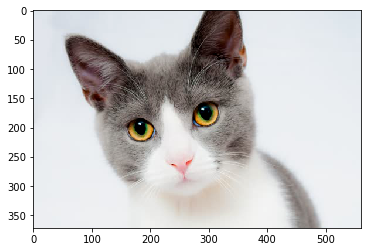

In [686]:
# Без афинных преобразований, за один проход не должно быть значительных 
# изменений, потому что начальные значения mean = 0 и var = 1
bn = BatchNorm2d(3, beta = 0.9, afine=False)
tensor = cat_tensor.unsqueeze(0)
o_image = bn(tensor)
o_image = o_image.squeeze(0)
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


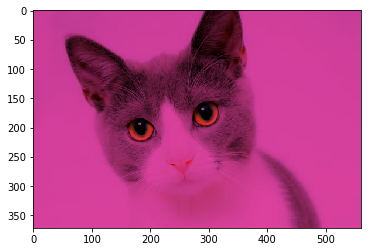

In [713]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
bn = BatchNorm2d(3, afine=True)
tensor = cat_tensor.unsqueeze(0)
o_image = bn(tensor)
o_image = o_image.squeeze(0)
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

### Проверим как реализация работает на большом сете картинок.

In [714]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [778]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')

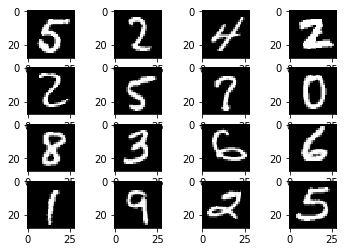

In [779]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на MNIST.
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются средние значения в процессе тренировки

In [780]:
def test_batch_norm(bn):
    bn.train(True)
    c_epoch = 1
    batch_size = 32
    mean_curve = []
    var_curve = []
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ float(bn.v) ] 
            var_curve +=  [ float(bn.s) ]
    return mean_curve, var_curve

In [781]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

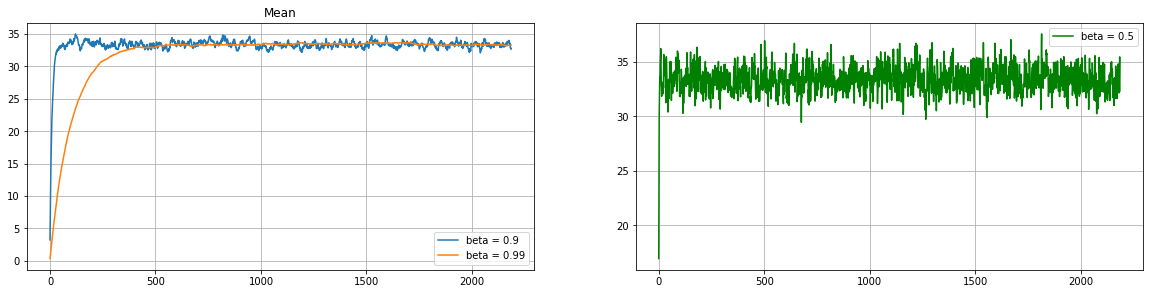

In [800]:
plt.figure(figsize=(20,10))

ax = plt.subplot(2,2,1)
plt.title('Mean')
ax.plot(mean_curve_09, label = 'beta = 0.9')
ax.plot(mean_curve_099, label='beta = 0.99')
ax.grid(True)
ax.legend()

ax = plt.subplot(2,2,2)
ax.plot(mean_curve_05, label = 'beta = 0.5', color = 'g')
ax.grid(True)
ax.legend()

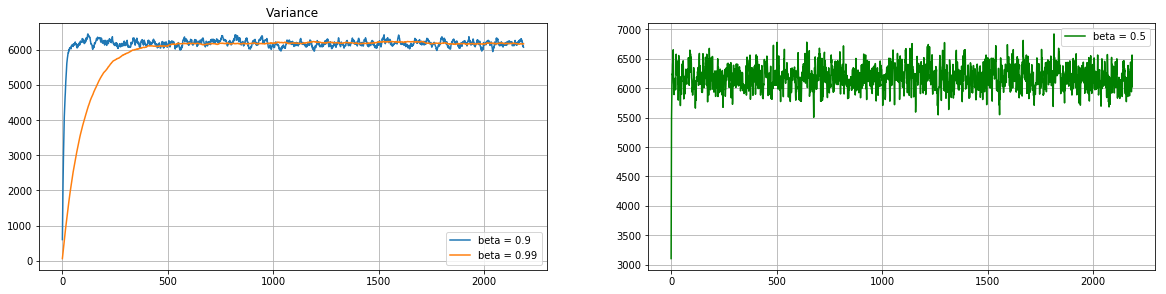

In [801]:
plt.figure(figsize=(20,10))

ax = plt.subplot(2,2,3)
plt.title('Variance')
ax.plot(var_curve_09, label = 'beta = 0.9',)
ax.plot(var_curve_099, label = 'beta = 0.99',)
ax.grid(True)
ax.legend()

ax = plt.subplot(2,2,4)
ax.plot(var_curve_05, label = 'beta = 0.5', color = 'g')
ax.grid(True)
ax.legend()

Посмотрим как повлияла батч нормализация на изображения.

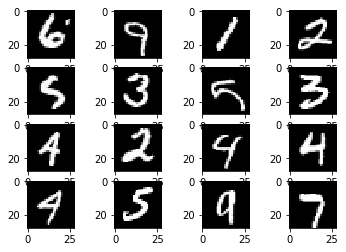

In [802]:
n=4
bn = bn_09
bn.train(False)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0)).squeeze(0).squeeze()
    plt.imshow(I, cmap='gray')

# Реализуем свой Adam и SGD c моментом.

**Задача:** реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), сделать выводы.


### Adam (Adaptive Moment Estimation) .


In [803]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            beta1, beta2 = group['betas']
            eps = group['eps']
            lr = group['lr']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['avg'] = torch.zeros_like(grad) # скользящее среднее по градинтам
                    state['avg_sq'] = torch.zeros_like(grad) # скользящее среднее по квадрату градиентов

                exp_avg, exp_avg_sq = state['avg'], state['avg_sq']
                state['step'] += 1

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                step = lr * math.sqrt(1 - beta2 ** state['step']) / (1 - beta1 ** state['step'])

                p.data.addcdiv_(-step, exp_avg, exp_avg_sq.sqrt() + eps)

        return loss

### SGD + Momentum.

In [804]:
from torch.optim import Optimizer

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        defaults = dict(lr=lr, beta=beta)
        super(SGD, self).__init__(params, defaults)

    def step(self):
        loss = None
        for group in self.param_groups:
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue                                
                grad = p.grad.data
                state = self.state[p]
                
                if beta != 0:
                    if len(state) == 0:
                        state['grad'] = torch.zeros_like(grad)
                    old_grad = state['grad']
                    grad = beta * old_grad + (1 - beta) * grad                    

                p.data = p.data - lr * grad

        return loss


In [911]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data'][:70000:4]
Y = mnist['target'].astype('int')[:70000:4]
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')

In [906]:
USE_CUDA = False

In [912]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.BatchNorm2d(1))

        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        self.net.add_module('relu_1', nn.ReLU())
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
        
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5))
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x

In [913]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward() # градиент
            optimizer.step()  # обновление весов
        avg_epoch_loss = loss_acc / (nbatches)
        #print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    return loss_curve

### SGD без момента.

In [914]:
learning_rates = [0.1, 0.01, 0.0001]
loss_sgd = []

for learning_rate in learning_rates: 
    net = Net(batchnorm=True)
    optimizer = SGD(net.parameters(), lr = learning_rate, beta = 0.0)
    loss_curve = fit_net(20, net, optimizer)
    print('Learning rate: %f. Final loss: %f' % (learning_rate, loss_curve[-1]))
    loss_sgd.append(loss_curve)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Learning rate: 0.100000. Final loss: 0.001481
Learning rate: 0.010000. Final loss: 0.018031
Learning rate: 0.000100. Final loss: 0.930575


### SGD с моментом.

In [915]:
learning_rates = [0.1, 0.01, 0.001]
betas = [0.9, 0.99, 0.5]
loss_sgd_momentum = []

for learning_rate, beta in zip(learning_rates, betas):
    net = Net(batchnorm=True)
    optimizer = SGD(net.parameters(), lr=learning_rate, beta = beta)
    loss_curve = fit_net(20, net, optimizer)
    print('Learning rate: %f, beta: %f. Final loss: %f' % (learning_rate, beta, loss_curve[-1]))
    loss_sgd_momentum.append(loss_curve)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Learning rate: 0.100000, beta: 0.900000. Final loss: 0.014457
Learning rate: 0.010000, beta: 0.990000. Final loss: 1.026300
Learning rate: 0.001000, beta: 0.500000. Final loss: 0.177387


### Adam.

In [916]:
learning_rates = [0.1, 0.01, 0.001]
loss_adam = []
for learning_rate in learning_rates: 
    net = Net(batchnorm=True)
    optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    loss_curve = fit_net(20, net, optimizer)
    print('Learning rate: %f. Final loss: %f' % (learning_rate, loss_curve[-1]))
    loss_adam.append(loss_curve)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Learning rate: 0.100000. Final loss: 2.302585
Learning rate: 0.010000. Final loss: 0.249195
Learning rate: 0.001000. Final loss: 0.009671


## Кривые обучения и выводы.

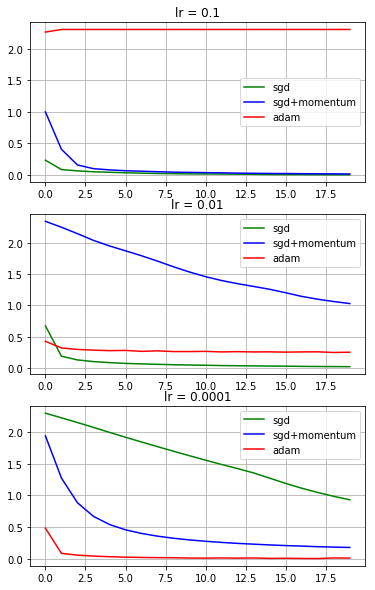

In [917]:
plt.figure(figsize=(6, 10))

ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

ax1.set_title('lr = 0.1')
ax1.plot(loss_sgd[0], 'g', label='sgd')
ax1.plot(loss_sgd_momentum[0], 'b', label='sgd+momentum')
ax1.plot(loss_adam[0], 'r', label='adam')
ax1.grid(True)
ax1.legend()

ax2.set_title('lr = 0.01')
ax2.plot(loss_sgd[1], 'g', label='sgd')
ax2.plot(loss_sgd_momentum[1], 'b', label='sgd+momentum')
ax2.plot(loss_adam[1], 'r', label='adam')
ax2.grid(True)
ax2.legend()

ax3.set_title('lr = 0.0001')
ax3.plot(loss_sgd[2], 'g', label='sgd')
ax3.plot(loss_sgd_momentum[2], 'b', label='sgd+momentum')
ax3.plot(loss_adam[2], 'r', label='adam')
ax3.grid(True)
ax3.legend()

1. Наименьшее значение loss'а получилось у обычного SGD (0.0014), при значении lr = 0.1. При этом lr, Adam не обучается, а SGD+m показывает результат на порядок хуже (0.014).
2. При уменьшении lr, SGD+m начинает опережать обычный SGD, т.к. не зависает в локальных минимумах из-за маленького шага.
3. При всех значениях lr, Adam быстро достигает своего минимума, при уменьшении lr, Adam скорее всего улучшит результат SGD, т.к. имеет большую скорость обучения при низком lr.

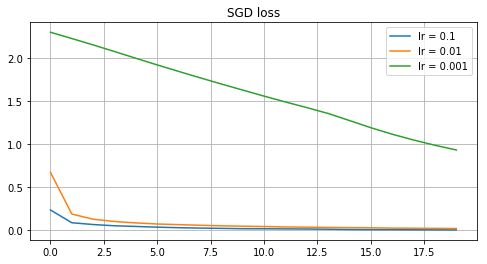

In [945]:
plt.figure(figsize=(8, 4))
plt.title('SGD loss')
plt.plot(loss_sgd[0], label='lr = 0.1')
plt.plot(loss_sgd[1], label='lr = 0.01')
plt.plot(loss_sgd[2], label='lr = 0.001')
plt.grid(True)
plt.legend()

1. SGD показывает наилучшие результаты при наибольшем из трёх lr. При дальнейшем увеличении lr, loss рано или поздно начнёт расти, т.к. SGD начнём "перепрыгивать" через минимумы из-за слишком большого шага.
2. Для обучения с lr = 0.0001 требуется больше эпох (или больший размер батча).

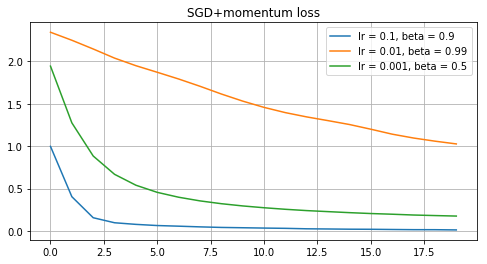

In [944]:
plt.figure(figsize=(8, 4))
plt.title('SGD+momentum loss')
plt.plot(loss_sgd_momentum[0], label='lr = 0.1, beta = 0.9')
plt.plot(loss_sgd_momentum[1], label='lr = 0.01, beta = 0.99')
plt.plot(loss_sgd_momentum[2], label='lr = 0.001, beta = 0.5')
plt.grid(True)
plt.legend()

1. При самом большом beta = 0.99 происходит снижение скорости обучения, видимо из-за того, что "перепрыгиваются" минимумы loss'а. При небольшом уменьшении beta (до 0.9) этот эффект пропадает, даже не смотря на увеличение lr. (Т.е. в данном случае большой момент мешает обучению).
2. lr = 0.001 недостаточно для достаточно быстрого обуения при таком маленьком значении beta. Заметно, что минимум loss'a не был достигнут к 20 эпохе.

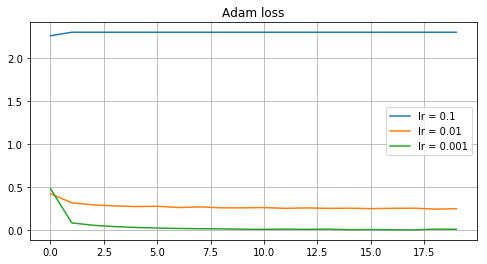

In [943]:
plt.figure(figsize=(8, 4))
plt.title('Adam loss')
plt.plot(loss_adam[0], label='lr = 0.1')
plt.plot(loss_adam[1], label='lr = 0.01')
plt.plot(loss_adam[2], label='lr = 0.001')
plt.grid(True)
plt.legend()

1. При больших значениях lr сеть не обучается.
2. Видно, что при уменьшении lr, достигаются меньшие значения loss'a, хотя при этом требуется больше времени на обучение.